In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
import seaborn as sns

import torch
from opacus.accountants import RDPAccountant

In [2]:
# Set the seaborn style
sns.set_style("darkgrid")

# Use seaborn color palette
palette = sns.color_palette("colorblind")
red = palette[3]
green = palette[2]
blue = palette[0]

In [3]:
# Define epsilon
epsilon = 1.0

# Define the list of point values
y_points_pure_dp = np.array([0.2, 0.1, 1.0, 1.6, 1.7, 1.2, 0.1, 0.3])
x_points = np.linspace(-epsilon, epsilon, len(y_points_pure_dp))

# Create a smooth curve between the points
x_smooth = np.linspace(x_points.min(), x_points.max(), 500)
spl = make_interp_spline(x_points, y_points_pure_dp, k=3)  # k=3 for cubic spline
y_smooth_pure_dp = spl(x_smooth)

In [4]:
y_apx_dp_left = np.array([0.0, 0.03, 0.02, 0.0]) - 0.2
y_apx_dp_center = np.array([1.3, 1.25, 1.35, 1.45, 1.3, 1.4, 1.35]) - 0.6
y_apx_dp_right = np.array([0.0, 0.04, 0.03, 0.0]) - 0.2

x_apx_dp_left = np.linspace(-1.5, -1.2, len(y_apx_dp_left))
x_apx_dp_center = np.linspace(-epsilon, epsilon, len(y_apx_dp_center))
x_apx_dp_right = np.linspace(1.1, 1.4, len(y_apx_dp_right)) + 0.6

x_smooth_apx_left = np.linspace(x_apx_dp_left.min(), x_apx_dp_left.max(), 500)
x_smooth_left_spl = make_interp_spline(x_apx_dp_left, y_apx_dp_left, k=3) # k=3 for cubic spline
y_smooth_apx_dp_left = x_smooth_left_spl(x_smooth_apx_left)
x_smooth_apx_center = np.linspace(x_apx_dp_center.min(), x_apx_dp_center.max(), 500)
x_smooth_center_spl = make_interp_spline(x_apx_dp_center, y_apx_dp_center, k=3) # k=3 for cubic spline
y_smooth_apx_dp_center = x_smooth_center_spl(x_smooth_apx_center)
x_smooth_apx_right = np.linspace(x_apx_dp_right.min(), x_apx_dp_right.max(), 500)
x_smooth_right_spl = make_interp_spline(x_apx_dp_right, y_apx_dp_right, k=3) # k=3 for cubic spline
y_smooth_apx_dp_right = x_smooth_right_spl(x_smooth_apx_right)


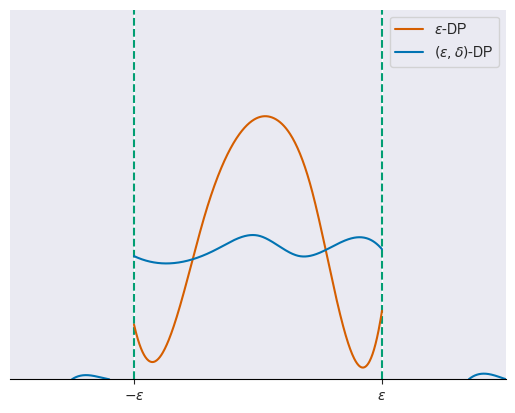

In [5]:
# Create the plot
fig, ax = plt.subplots()

# Plot the vertical lines at epsilon and -epsilon
ax.axvline(x=epsilon, color=green, linestyle='--')
ax.axvline(x=-epsilon, color=green, linestyle='--')

# Plot the smooth function
ax.plot(x_smooth, y_smooth_pure_dp, color=red, label=r'$\epsilon$-DP')
ax.plot(x_smooth_apx_left, y_smooth_apx_dp_left, color=blue, label=r'$(\epsilon,\delta)$-DP')
ax.plot(x_smooth_apx_center, y_smooth_apx_dp_center, color=blue, label='')
ax.plot(x_smooth_apx_right, y_smooth_apx_dp_right, color=blue, label='')

# Plot the original points
# ax.scatter(x_points, y_points, color='blue')

# Customize the plot
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.set_xticks([-1.0, 1.0])
ax.set_xticklabels([r'$-\epsilon$', r'$\epsilon$'])
ax.set_yticks([])

# Set the limits for x and y axes
ax.set_xlim((-2.0, 2.0))
ax.set_ylim((-0.2, 2.5))

# Add the label for the smooth function
ax.legend()

plt.savefig('dp_vs_apx_dp.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [96]:
def basic_composition_bound(T: int, q: float, epsilon_i: float) -> np.ndarray:
    ts = np.arange(0, T)
    return q * epsilon_i * ts

def advanced_composition_bound(T: int, q: float, delta: float, epsilon_i: float) -> np.ndarray:
    ts = np.arange(0, T)
    return q * 2 * epsilon_i * np.sqrt(2 * ts * np.log(1 / delta))

def renyi_composition_bound(T: int, q: float, epsilon_i: float, delta: float, alpha: float | int) -> np.ndarray:
    ts = np.arange(0, T)
    return q * ((epsilon_i * ts) + np.log(1/delta)/(alpha - 1))

def opacus_composition_bound(T: int, q: float, epsilon_i: float, delta: float, alpha: float | int) -> np.ndarray:
    ts = np.arange(0, T)
    return q * ((epsilon_i * ts) + np.log((alpha - 1) / alpha) - (np.log(delta) + np.log(alpha)) / (alpha - 1))

In [102]:
# q = 1 / 409
q = 1.0
delta = 1e-5
T = 500

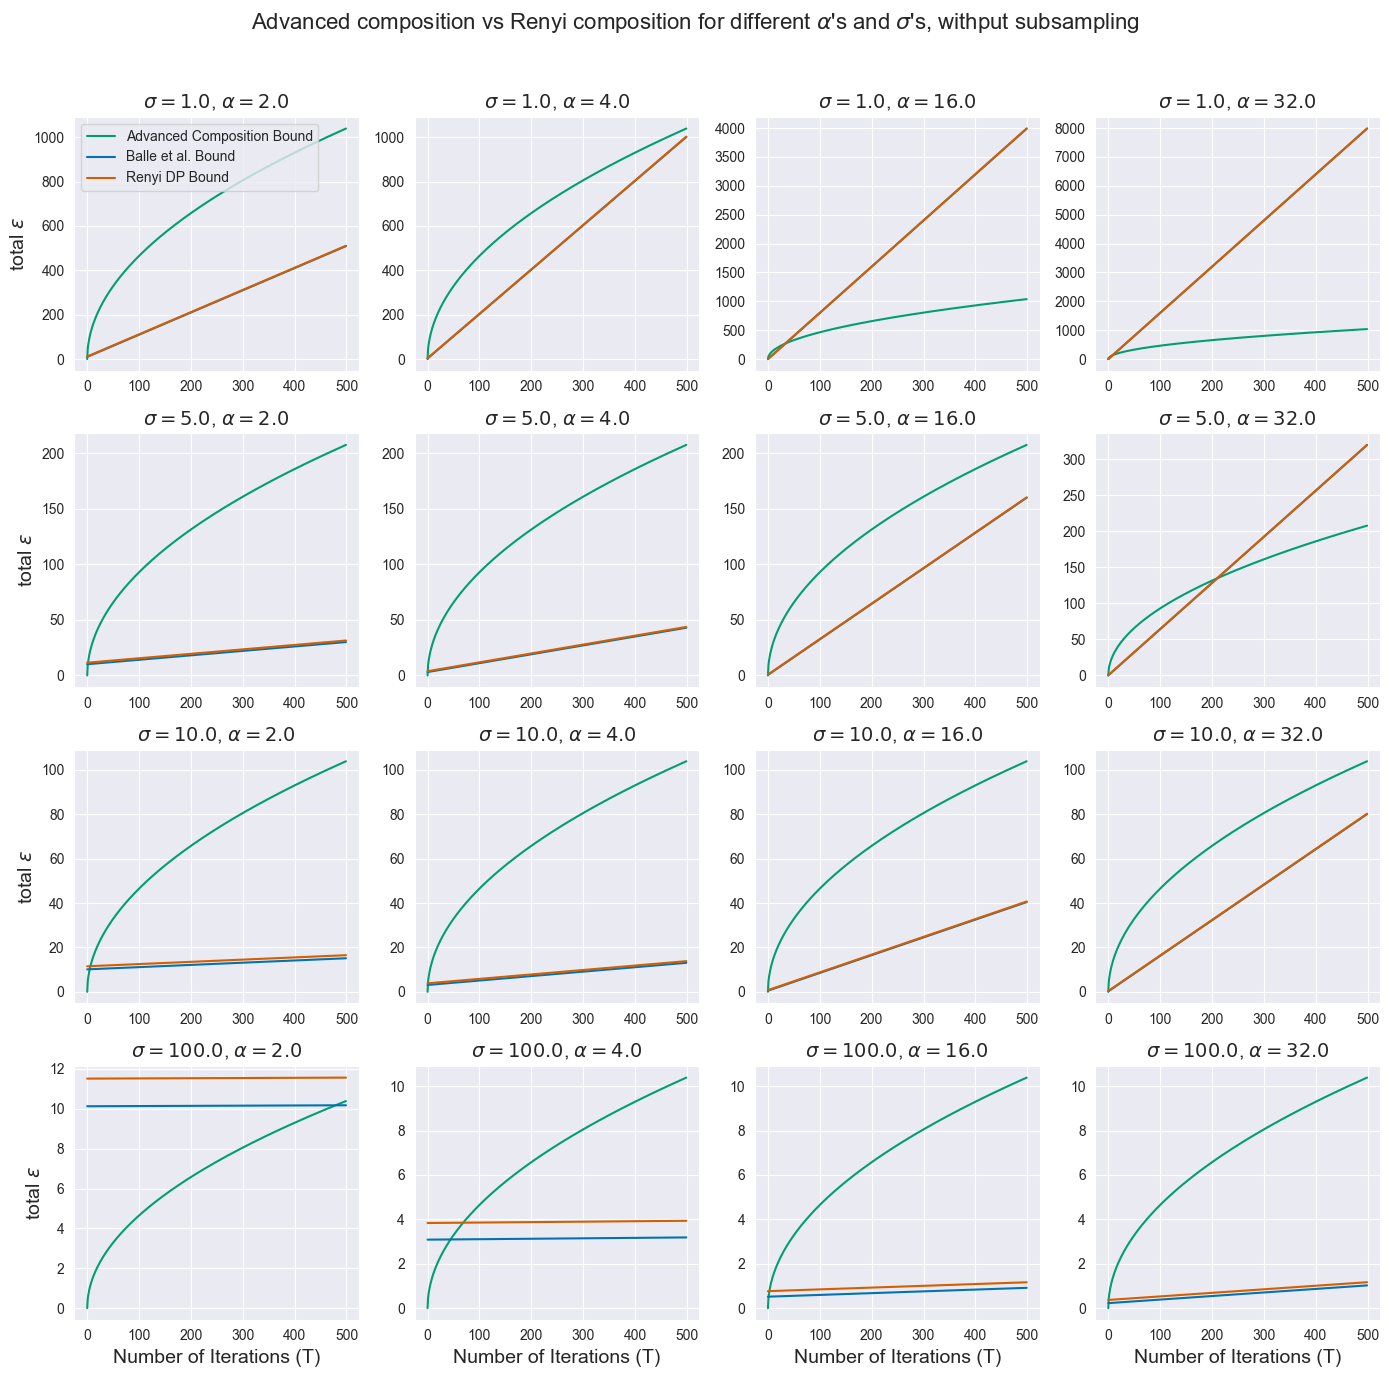

In [104]:
fig, axs = plt.subplots(4, 4, figsize=(14, 14))

for (i, sigma) in enumerate([1.0, 5.0, 10.0, 100.0]):
    for (j, alpha) in enumerate([2.0, 4.0, 16.0, 32.0]):

        gauss_epsilon_i = np.sqrt(2 * np.log(1.25 / delta) / sigma**2)
        rdp_epsilon_i =  alpha / (2 * sigma**2)

        advanced_bound = advanced_composition_bound(T, q, delta, gauss_epsilon_i)
        renyi_bound = renyi_composition_bound(T, q, rdp_epsilon_i, delta, alpha)
        opacus_bound = opacus_composition_bound(T, q, rdp_epsilon_i, delta, alpha)

        # First subplot with all three functions
        axs[i][j].plot(advanced_bound, label='Advanced Composition Bound', c=green)
        axs[i][j].plot(opacus_bound, label='Balle et al. Bound', c=blue)
        axs[i][j].plot(renyi_bound, label='Renyi DP Bound' , c=red)
        axs[i][j].set_title(f"$\\sigma={sigma}$, $\\alpha={alpha}$", fontsize=14)

        axs[i][j].grid(True)
        if i == 0 and j == 0:
            axs[i][j].legend()
        if j == 0:
            axs[i][j].set_ylabel('total $\\epsilon$', fontsize=14)
        if i == 3:
            axs[i][j].set_xlabel('Number of Iterations (T)', fontsize=14)

# Add a super title
fig.suptitle("Advanced composition vs Renyi composition for different $\\alpha$'s and $\\sigma$'s, withput subsampling", fontsize=16)

plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
plt.savefig('../../../thesis-report/img/composition_bounds_different_alpha_sigma.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
# Create a table with the values of T for different values of epsilon
# epsilon = 1.1, 2, 4, 5, 10



In [90]:
rdp_accountant = RDPAccountant()
actual_q = 1 / 409

actual_sigma = 1.0
actual_t = 0
actual_res = (0.0, 0.0)

In [91]:
rdp_accountant.step(noise_multiplier=actual_sigma, sample_rate=actual_q)
actual_t += 1
actual_res = rdp_accountant.get_privacy_spent(delta=delta, alphas=[2.0, 4.0, 6.0, 8.0, 10.0, 16.0, 32.0, 64.0])
actual_res, sigma, actual_t, actual_t * actual_q

((0.9180651056567095, 10.0), 100.0, 1, 0.0024449877750611247)

In [92]:
while actual_res[0] < 1.5:
    rdp_accountant.step(noise_multiplier=actual_sigma, sample_rate=actual_q)
    actual_t += 1
    actual_res = rdp_accountant.get_privacy_spent(delta=delta, alphas=[2.0, 4.0, 8.0, 16.0])

actual_res, sigma, actual_t, actual_t * actual_q

((1.5000327364691488, 8.0), 100.0, 6673, 16.315403422982886)

In [93]:
while actual_res[0] < 2:
    rdp_accountant.step(noise_multiplier=actual_sigma, sample_rate=actual_q)
    actual_t += 1
    actual_res = rdp_accountant.get_privacy_spent(delta=delta, alphas=[2.0, 4.0, 8.0, 16.0])

actual_res, sigma, actual_t, actual_t * actual_q

((2.000024063049243, 8.0), 100.0, 18342, 44.84596577017115)

In [94]:
while actual_res[0] < 4:
    rdp_accountant.step(noise_multiplier=actual_sigma, sample_rate=actual_q)
    actual_t += 1
    actual_res = rdp_accountant.get_privacy_spent(delta=delta, alphas=[2.0, 4.0, 8.0, 16.0])

actual_res, sigma, actual_t, actual_t * actual_q

((4.0000322171994735, 8.0), 100.0, 65019, 158.97066014669926)

In [95]:
while actual_res[0] < 10:
    rdp_accountant.step(noise_multiplier=actual_sigma, sample_rate=actual_q)
    actual_t += 1
    actual_res = rdp_accountant.get_privacy_spent(delta=delta, alphas=[2.0, 4.0, 8.0, 16.0])

actual_res, sigma, actual_t, actual_t * actual_q

((10.000019112029056, 4.0), 100.0, 332020, 811.7848410757946)